In [1]:
import torch
import torchvision

#
# Confirm environment is working as expected
#
print(torch.__version__)
print(torchvision.__version__)
_ = torchvision.ops.nms


2.6.0+cu124
0.21.0+cu124


In [2]:
import os
import requests
from tqdm.notebook import tqdm


def download_file(uri: str, local_path: str) -> None:
    if not os.path.exists(local_path):
        response = requests.get(uri, stream=True)
        response.raise_for_status()  # Raise an error for bad responses
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192
        with open(local_path, "wb") as file, tqdm(
                total=total_size, unit="B", unit_scale=True, desc=local_path
        ) as progress :
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    file.write(chunk)
                    progress.update(len(chunk))


pretrained="https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl"
download_file(pretrained, "/project/data/model_final_a3ec72.pkl")



/project/data/model_final_a3ec72.pkl:   0%|          | 0.00/254M [00:00<?, ?B/s]

In [1]:
from welfareobs.detectron.detectron_configuration import get_configuration
from welfareobs.detectron.detectron_calls import image_loader, predict
from detectron2.config import instantiate
from detectron2.checkpoint import DetectionCheckpointer

# Instantiate the model configuration (this embeds the feature extraction)
# NOTE: the `root` path contains checkpoints we have trained on features
# files that should exist in the root are:
# * "checkpoint.pth" <-- weights of the finetuned backbone
# * "similarity.pkl" <-- deep features mapping file (maps to the finetuning training set classes)
dimensions = 384
model = instantiate(
    get_configuration(
        "/project/data/results/wod-1-md",
        backbone="hf-hub:BVRA/wildlife-mega-L-384",
        dimensions=dimensions
    )
)
# then load it with the pretrained backbone
DetectionCheckpointer(model).load("/project/data/model_final_a3ec72.pkl")
model.eval()
model.to("cuda")
print("Model load complete...")

output = predict(
    image_loader(
        "20230920_091213.jpg",
        384
    ),
    model
)
output = output["instances"]
print(f"Output type is {type(output)}")
print(f"Available fields in the result: {','.join([o for o in output.get_fields().keys()])}")
_reids = list(output.get("reid_embeddings").cpu().numpy().flatten())
_classes = list(output.get("pred_classes").cpu().numpy())
_boxes = list(output.get("pred_boxes").cpu().numpy())
_masks = list(output.get("pred_masks").cpu().numpy())
_scores = list(output.get("scores").cpu().numpy())
for i in range(len(output)):
    if _classes[i] == 23:
        print(f"Giraffe: {_reids[i]} score={_scores[i]}")





INFO:datasets:PyTorch version 2.6.0 available.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (BVRA/wildlife-mega-L-384)
INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /project/data/model_final_a3ec72.pkl ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /project/data/model_final_a3ec72.pkl ...
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'
/opt/conda/envs/wt/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model load complete...
Available fields in the result: pred_boxes,scores,pred_classes,pred_masks,reid_embeddings
Giraffe: 3 score=0.37448373436927795


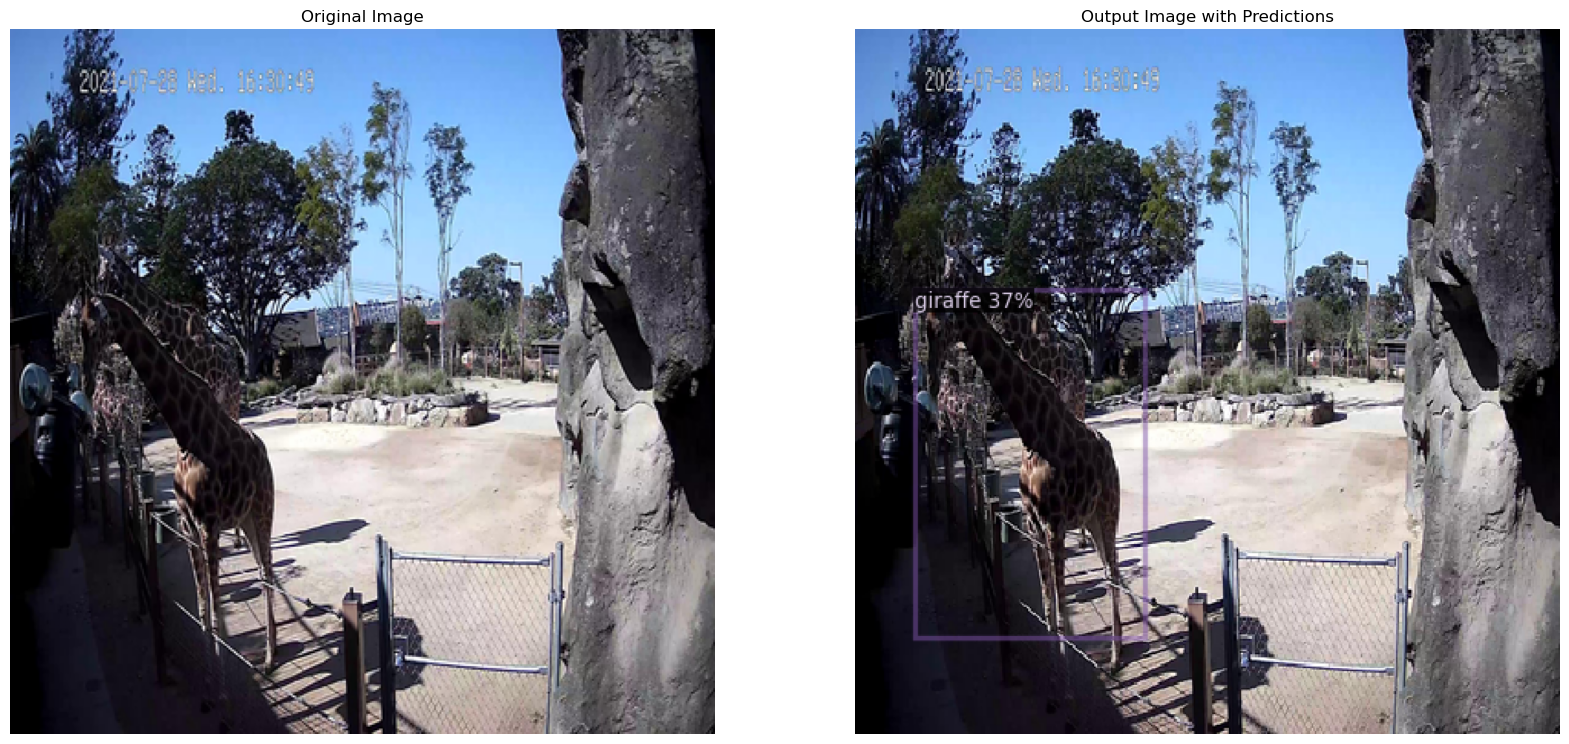

In [11]:
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data.catalog import MetadataCatalog
from detectron2.structures import Instances, Boxes


metadata = MetadataCatalog.get("coco_2017_val")
# Convert image to float and scale to [0, 1] for matplotlib
image = np.array(Image.open("20230920_091213.jpg").convert("RGB").resize((384, 384), Image.LANCZOS))
image_rgb = image.astype(np.float32) / 255.0
v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)

giraffe_mask = output.pred_classes == 23
filtered_instances = Instances((384, 384), **{
    "pred_boxes": output.pred_boxes[giraffe_mask],
    "scores": output.scores[giraffe_mask],
    "pred_classes": output.pred_classes[giraffe_mask]
})
out = v.draw_instance_predictions(filtered_instances.to("cpu"))
output_image = out.get_image()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(output_image[:, :, ::-1])
axes[1].set_title("Output Image with Predictions")
axes[1].axis("off")
plt.axis("off")
plt.show()